[![Alt Right Community](/img/ALT_RIGHT.jpg)](https://www.jstor.org/stable/26984798?seq=1#metadata_info_tab_contents)

# The rise of far-right extremism speech between 2016 and 2020 
### Observed through a dataset of quotes from the press, highlighting the evolution of opinions and ideas that shape the past, present, and the future of our society.

$$ \\ $$

Project in Applied Data Analysis (CS-401)

*Team members: Camil Hamdane (SV), Clémentine lévy-Fidel (SV), Nathan Fiorellino (SV), Nathan Girard (SV)*



## 1. How to get started

### 1.1 Mount your drive to your notebook

It is possible to mount your Google Drive to Colab if you need additional storage or if you need to use files from it. To do that run (click on play button or use keyboard shortcut 'Command/Ctrl+Enter') the following code cell:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 

1.   After running the cell, URL will appear.

2.   Following this URL, you will be redirected to the page where you need to choose Google Drive account to mount to.

3.   You will further be asked to give Google Drive Stream a permission to access the chosen Google account

4.   After granting the access, authorization code will be given to you

5.   Copy the authorization code into the dedicated textbox in Colab under '*Enter your authorization code:*' writing

After copying the authorization code, you should get the message saying '*Mounted at /content/gdrive*'

Path to the files from the mounted Drive will then be '/content/drive/MyDrive/'. By opening the Files tab (left sidebar, folder icon) you should also be able to see the accessible files. Now, you can read the data directly from the Google Drive you mounted following the process above. Make sure you mounted the drive to which you saved the shortcut to the Quotebank data. 

### 1.2 Install the required libraries (*OPTIONAL*)

You don't need to perform this step if you have previously installed the libraries ([pandas](https://pandas.pydata.org), [seaborn](https://seaborn.pydata.org), [tld](https://pypi.org/project/tld/)) on an environment.

In [ ]:
# Installations
!pip install pandas==1.0.5 
!pip install seaborn
!pip install tld

In [ ]:
# Imports
import os
from google.colab import files

import pandas as pd
import numpy as np
import seaborn as sns

In [ ]:
# Constants 
input_path = '/content/drive/MyDrive/Quotebank/quotes-2020.json.bz2'
output_path = '/content/drive/MyDrive/EPFL/processed_quotes-2020.csv'

min_occurence = 10
min_probability = 0.6


## 2. Preprocessing



### 2.1 Extraction of the data

In this section, we extract the data and preprocess it, such that we can better conduct our analysis. The Data exploration brought us to choose the following filtering steps:

- Remove quotes with low numOccurences (less than **10**),
- Filter for samples with only **1** QID,
- Keep quotes whose probability is higher than **0.6**
- Remove **"phase"** feature of the dataframe

Pre-processing steps that we have not added yet but which we woul like to add in the future:
- Remove news outlets relaying less than a certain number of quotes, as they do not contribute to reflecting global trends.

Because of the huge size of the data and the limited capacity of the RAM provided by Google, we decided to process the data **per year**. In addition, chunks of data (per year) are processed sequentially to avoid exceed storage capacity. This preprocessing pipeline filters most of the data, such that **approximately 4%** of the initial data remains at the end. We obtain therefore clean and usable data for further analysis, stored in files named *"processed_quotes-20XX.csv"*, for each year. 

In [ ]:
# Definition of helper functions

def clean_chunk(chunk):
    """ 
        Cleans dataset chunk by removing unattributed quotes (quotes whose most probable speaker is unknown) or quotes whose speaker name is associated with more 
        than 1 alias removes 'probas' column and keep only quotes whose speaker probability is greater than 0.6 removes 'phase' column.
    """          
    chunk_clean = chunk.copy()
    
    # Filtering for samples containing exactly one QIDs
    chunk_clean = chunk_clean.loc[chunk[chunk['qids'].map(len) == 1].index]
    chunk_clean['qids'] = chunk_clean['qids'].apply(lambda qids: qids[0])
    
    # Remove samples with more than 1 speaker 
    if chunk_clean['probas'].dtype != 'float64': # In case the 'probas' column has already been pre-processed
        chunk_clean['probas'] = chunk_clean['probas'].apply(lambda probas: float(probas[0][1]))
    
    chunk_clean = chunk_clean[chunk_clean['probas'] > min_probability]
    
    # Remove Samples with low numOccurences
    chunk_clean = chunk_clean[chunk_clean['numOccurrences'] > min_occurence]
    
    # Removing phase feature
    if 'phase' in chunk_clean: # In case the 'phase' column has already been pre-processed
        chunk_clean = chunk_clean.drop('phase', axis = 1)
        
    return chunk_clean

def process_chunk(chunk):
    """
        Print the size of the chunk processed and the names of the columns. 
    """
    
    print(f'Processing chunk with {len(chunk)} rows')
    print(chunk.columns)
    print("")

#### a. Data Exploration

In this part, we focus on exploring the distribution of the number of occurences of the filtered dataset. AS an example for the year 2020, the distribution is shown below:

In [ ]:
df_reader = pd.read_json(path_to_file, lines=True, compression='bz2', chunksize=1000000)

df_2020 = pd.DataFrame()
for chunk in df_reader:
  process_chunk(chunk)
  chunk = clean_chunk(chunk)
  df_2020 = df_2020.append(chunk)

In [ ]:
import seaborn as sns
sns.histplot(df_2020['numOccurrences'], log_scale = True)

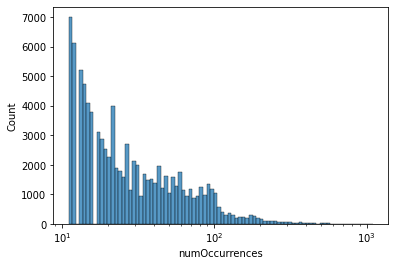

In [ ]:
df_2020.describe()


We notice that with this first filtering, the median is now at 23 occurences per quote, which tends to prove more the veracity of the quote than the preivous median of 1.

#### b. Pre-processing for further analysis

In this next cell we pre-process the chunks. As the cleaning of the data is very time consuming we have decided to limit ourselves to 5 chunks of 10'000 quotes.

In [ ]:
df_reader = pd.read_json(input_path, lines = True, compression = 'bz2', chunksize = 10000)

In [ ]:
# Extraction of the data and filtering  
for i,chunk in enumerate(df_reader):
  process_chunk(chunk)
  cleaned_chunk = clean_chunk(chunk)
  cleaned_chunk.to_csv(output_path, mode='a')

  #For this initial analysis we will limit us to 5 chunks
  if i==5:
    break


Processing chunk with 10000 rows
Index(['quoteID', 'quotation', 'speaker', 'qids', 'date', 'numOccurrences',
       'probas', 'urls', 'phase'],
      dtype='object')

Processing chunk with 10000 rows
Index(['quoteID', 'quotation', 'speaker', 'qids', 'date', 'numOccurrences',
       'probas', 'urls', 'phase'],
      dtype='object')

Processing chunk with 10000 rows
Index(['quoteID', 'quotation', 'speaker', 'qids', 'date', 'numOccurrences',
       'probas', 'urls', 'phase'],
      dtype='object')

Processing chunk with 10000 rows
Index(['quoteID', 'quotation', 'speaker', 'qids', 'date', 'numOccurrences',
       'probas', 'urls', 'phase'],
      dtype='object')

Processing chunk with 10000 rows
Index(['quoteID', 'quotation', 'speaker', 'qids', 'date', 'numOccurrences',
       'probas', 'urls', 'phase'],
      dtype='object')

Processing chunk with 10000 rows
Index(['quoteID', 'quotation', 'speaker', 'qids', 'date', 'numOccurrences',
       'probas', 'urls', 'phase'],
      dtype='object')